In [1]:
using Distances, DataFrames, Color, Gadfly, Distributions, Interact, Reactive

include("BlahutArimoto.jl")
include("InformationTheoryFunctions.jl")
include("ConversionFunctions.jl")
include("VisualizationFunctions.jl")
include("ThreeVariableBlahutArimoto.jl")

#make the default plot size a bit larger
set_default_plot_size(15cm, 12cm)

In [44]:
#set up taxonomy example
#include("TaxonomyExample.jl")
#w_vec, w_strings, a_vec, a_strings, p_w, U = setuptaxonomy()
#a_values = a_vec
#w_values = w_vec

#set up predator-prey example
include("PredatorPreyExample.jl")
w_values, w_strings, a_values, a_strings, p_w, U = setup_predator_prey_example()
num_acts = length(a_values)
a_vec = [1:num_acts]
num_worldstates = length(w_values)
w_vec = [1:num_worldstates]




#pre-compute utilities, find maxima
U_pre, Umax = setuputilityarrays(a_values,w_values,U)

#visualize utility
plt_utility = visualizeMatrix(U_pre, w_values, a_values, w_strings, a_strings, xlabel="w",
                              ylabel="a", legendlabel="U(a,w)")


#solve the example with one-step Blahut-Arimoto
β = 3 #inverse temperature
ε = 0.0001 #convergence critetion for BAiterations
maxiter = 10000 #maximum number of BA iterations

#initialize p(a) uniformly
num_acts = length(a_vec)
pa_init = ones(num_acts)/num_acts 

#Blahut-Arimotot iterations
p_agw_one, p_a_one, perf_df_one = BAiterations(pa_init, β, U_pre, p_w, ε, maxiter,
                                               compute_performance=true, performance_as_dataframe=true)

#visualize solution
plt_marg, plt_cond = visualizeBAsolution(p_a_one, p_agw_one, a_vec, w_vec, a_strings, w_strings,
                                         wlabel="Item bought w", alabel="Recommend a",
                                         legendlabel_marginal="p(a)", legendlabel_conditional="p*(a|w)",
                                         suppress_vis=true);

display(plt_utility)
display(plt_cond)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 2 
 5 
 3 
 0 
 1 
 4 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 U(a,w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Item bought w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Recommend a

In [176]:
#approaching sequential
#β1 = 10 #inverse temperature for p(o)→p(o|w)
#β2 = 10 #inverse temperature for p(a)→p(a|o)
#β3 = 0.01 #inverse temperature for p(a|o)→p(a|o,w)


#β1=β3 and β2=∞ is identical to the one-variable case
#β1 = 1.3 #inverse temperature for p(o)→p(o|w)
#β2 = Inf #inverse temperature for p(a)→p(a|o)
#β3 = 1.3 #inverse temperature for p(a|o)→p(a|o,w)

#parallel β2=∞
β1 = 3 #inverse temperature for p(o)→p(o|w)
β2 = Inf #inverse temperature for p(a)→p(a|o)
β3 = 3 #inverse temperature for p(a|o)→p(a|o,w)

#sequential β3=0
#β1 = 8 #inverse temperature for p(o)→p(o|w)
#β2 = 10 #inverse temperature for p(a)→p(a|o)
#β3 = 0 #inverse temperature for p(a|o)→p(a|o,w)


ε = 0.0001 #convergence critetion for BAiterations
maxiter = 2000 #maximum number of BA iterations

#cardinality of percept
num_obs = 13#length(a_vec) #cardinality of percept is equal to action-space
o_vec = [1:num_obs]
o_strings = map((x)->"o"*string(x), o_vec)

num_worldstates = length(w_vec)

#manually initialize p(o|w) and p(a|o,w)
#initialize p(o|w) with the one-step solution
#pogw_init = p_agw_one

#initalize in order to maximize H(O) - i.e. sparse, diagonal initialization
#this is inspired by layer-wise pre-training in stacked auto-encoders, where
#in the unsupervised pre-training step I(O;W) is maximized, keeping in mind that
#in a deterministic model H(O|W) is fixed.
#What could be a justification for doing this?
#
#alternatively, instead of maximizing H(O) try to set I(O;W) exactly at the limit
#that you later impose (however, this is technically difficult, since we only know
#the inv. temperature and not the exact limit on I)
#
#this doesn't seem to help, but it also doesn't seem to hurt... (and in cases
#where you don't have the hand-crafted perceptual model, this could be used)
#TODO: perhaps randomly re-shuffle columns, such that different initializations
#could in principle lead to different solutions
#TODO: perhaps also try initializing p(a|o)?
#
numw = num_worldstates
numo = num_obs
numa = num_acts
if(numw<=numo)
    pogw_init = eye(numo,numw)
else
    for b in numo:numo:numw
        display(b)
        if b==numo
            pogw_init = eye(numo, numo)
        else
            pogw_init = [pogw_init eye(numo,b-size(pogw_init,2))]
        end
    end
    extra = numw - size(pogw_init,2)
    if extra>0
        pogw_init = [pogw_init eye(numo,extra)]
    end
end
#make sure that all elements are nonzero
pogw_init += rand(size(pogw_init)) * 0.1  #TODO: this factor depends on the number of rows in pogw_init... fix this!
for j in 1:numw
    pogw_init[:,j] /= sum(pogw_init[:,j])
end

#initialize p(o|w) randomly
pogw_init = rand(num_obs, num_worldstates)
#initialize p(o|w) uniformly
#pogw_init = ones(num_obs, num_worldstates)
#normalize
#for j in 1:num_worldstates
#    pogw_init[:,j] /= sum(pogw_init[:,j])
#end


#initialize p(a|o,w) randomly
p_agow_init = rand(num_acts, num_obs, num_worldstates)         
#initialize p(a|o,w) uniformly
#p_agow_init = ones(num_acts, num_obs, num_worldstates)         
#normalize
for j in 1:num_worldstates       
    for k in 1:num_obs
        p_agow_init[:,:,j] /= sum(p_agow_init[:,:,j])
    end
end   


#This function performs Blahut-Arimoto iterations for the three-variable general case
po, pa, pogw, pago, pagow, pagw, performance_df = threevarBAiterations(pogw_init, p_agow_init,
                                                  β1, β2, β3, U_pre, p_w, ε, maxiter,
                                                  compute_performance=true, performance_per_iteration=true,
                                                  performance_as_dataframe=true);

Questions/Observations:
*  Parallel case $\beta_2=\infty$: (initialization doesn't seem to matter so much)
 * To reproduce the one-step case: $\beta_1 = \beta_3$
    * Initialize $p(o|w)$ uniformly, $(p(a|o,w)$ randomly -> works with $I(A;W|O)=0$
    * Initialize $p(o|w)$ uniformly, $(p(a|o,w)$ uniformly -> works with $I(O;W)=0$, but maybe this is a degenerate case, where nothing really works?
    * Random initialization of $p(o|w)$ -> seems to work as well
    * Initialize $p(o|w)$ with one-step solution -> ?
    * Initialize $p(o|w)$ in a diagonal fashion (sparse) -> seems to work as well
 * In case of different $\beta_1$ and $\beta_3$
    * It seems to make no big difference how you initialize $p(o|w)$?
    * Maybe $p(a|o,w)$ plays a bigger role now?
 * Perhaps more constraints would be needed - like a minimal percept (using as few different observations as possible)?
    
    
*  Serial case $\beta_3=0$ (initialization is really important here!)
 * To reproduce MEU-solution:
    * Initialize $p(o|w)$ in a diagonal-matrix fashion - perhaps the one-step solution is a nice initialization (but this only works in case the percept has the same cardinality as the action space - maybe it would be better to find a more general pretraining scheme...)?
 * To reproduce one-step solution:
    * Initialize with one-step solution and increase $\beta$ a bit (until the value of the objective is identical), use same $\beta$ for both channels
    * Shouldn't it also work if you set one of the channels to $\infty$ and the other to $\beta$?
 * What happens when you initialize with one-step solution?
 * What happens when you initialize $p(o|w)$ randomly/uniformly?
 * What role does the initialization of $p(o|w,a)$ play and how does it relate to the initialization of $p(a|o)$?
 
**TODO: plot solutions of several runs (random-init, uniform-init, one-step solution init, diagonal init) into the rate-distortion curve (determined by the one-step case).** Can you see any qualitative differences?  
With this argument, the parallel case can never be "better" than the one-step case, but perhaps there are regimes that produce interesting percepts (however the range of temperatures to allow for that seems to be quite narrow). Maybe the parallel case only starts making sense when the utility depends on the percept as well as in Dan's search in two dimensions with different search cost? (But what about the memory-adaptation paper then - maybe the example is just bad...?)  

**Maybe the parallel case starts making more sense when the cardinality of the percept is reduced?**


Parallel case: $p(a|o)$ can be quite deterministic (since there is no cost for $p(a)\rightarrow p(a|o)$ which means that $I(A;O)$ can be very large. Therefore, if the percept has a sufficient cardinality, most of the mapping will happen in $p(a|o)$. If you limit the cardinality of the percept, then it starts to play the role of a model... (explore this further). But at the same time reducing the cardinality of $o$ also has the effect of imposing a maximum channel capacity (because the maximum entropy over $o$ is more limited and $I(O;W) \leq H(O)$)

If $\beta_1 \ll \beta_3$ everything happens in $p(a|o,w)$ and all the MI is in $I(A;W|O)$

If $\beta_1 < \beta_3$ things happen in both channels ($\beta_3$ can only be slightly higher than $\beta_1$).


If $\beta_1 = \beta_3$ and the percept has a low cardinality, the one-step case is reproduced. In principle here, both MI terms could do interesting things and split the task, but it should also be equal to process everything on one channel and do nothing on the other channel. Here it seems that this is mostly happening (everything on $I(O;W)$) except when both $p(o|w)$ and $p(a|o,w)$ are initialized uniformly. Then everything seems to happen on $I(A;W|O)$ (but perhaps this is a degenerate case where the iterations get stuck because everything is too symmetric?).

If $\beta_1 > \beta_3$ things should happen on both channels, but they don't seem to - is there a reason for this? Perhaps it is because you need a good $p(o|w)$ for the prior of the second stage $p(a|o)$?

If $\beta_1 \gg \beta_3$ everything happens on $I(O;W)$.


In [177]:
#plot convergence (i.e. evolution across BA iterations)
plot_convergence_MI, plot_convergence_Util = plot_three_var_BA_convergence(performance_df);

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 
 Objective J 
 
 
 
 
 
 
 
 E[U] 
 
 
 
 
 
 
 
 
 
 
 Iteration 
 
 
 -500 
 -400 
 -300 
 -200 
 -100 
 0 
 100 
 200 
 300 
 400 
 500 
 600 
 700 
 800 
 900 
 -400 
 -380 
 -360 
 -340 
 -320 
 -300 
 -280 
 -260 
 -240 
 -220 
 -200 
 -180 
 -160 
 -140 
 -120 
 -100 
 -80 
 -60 
 -40 
 -20 
 0 
 20 
 40 
 60 
 80 
 100 
 120 
 140 
 160 
 180 
 200 
 220 
 240 
 260 
 280 
 300 
 320 
 340 
 360 
 380 
 400 
 420 
 440 
 460 
 480 
 500 
 520 
 540 
 560 
 580 
 600 
 620 
 640 
 660 
 680 
 700 
 720 
 740 
 760 
 780 
 800 
 -500 
 0 
 500 
 1000 
 -400 
 -350 
 -300 
 -250 
 -200 
 -150 
 -100 
 -50 
 0 
 50 
 100 
 150 
 200 
 250 
 300 
 350 
 400 
 450 
 500 
 550 
 600 
 650 
 700 
 750 
 800 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M21.21,73.97 L 21.51 73.72 21.82 73.6 22.12 73.39 22.43 73.34 22.73 73.22 23.04 73.22 23.34 73.15 23.65 73.17 23.95 73.12 24.26 73.15 24.56 73.1 24.87 73.13 25.17 73.08 25.48 73.1 25.78 73.06 26.09 73.05 26.39 73.04 26.7 73.01 27.01 73.02 27.31 72.99 27.62 73 27.92 73.04 28.23 72.96 28.53 73.02 28.84 72.95 29.14 73 29.45 72.95 29.75 73 30.06 72.96 30.36 73 30.67 72.98 30.97 73.01 31.28 73.01 31.58 73.03 31.89 73.03 32.19 73.05 32.5 73.06 32.8 73.07 33.11 73.08 33.42 73.08 33.72 73.09 34.03 73.1 34.33 73.1 34.64 73.11 34.94 73.11 35.25 73.11 35.55 73.11 35.86 73.12 36.16 73.12 36.47 73.12 36.77 73.12 37.08 73.12 37.38 73.13 37.69 73.13 37.99 73.13 38.3 73.13 38.6 73.13 38.91 73.13 39.22 73.13 39.52 73.13 39.83 73.14 40.13 73.14 40.44 73.14 40.74 73.14 41.05 73.14 41.35 73.14 41.66 73.14 41.96 73.14 42.27 73.14 42.57 73.14 42.88 73.14 43.18 73.14 43.49 73.14 43.79 73.14 44.1 73.14 44.4 73.14 44.71 73.14 45.01 73.14 45.32 73.14 45.63 73.15 45.93 73.15 46.24 73.15 46.54 73.15 46.85 73.15 47.15 73.15 47.46 73.15 47.76 73.15 48.07 73.15 48.37 73.15 48.68 73.15 48.98 73.15 49.29 73.15 49.59 73.15 49.9 73.15 50.2 73.15 50.51 73.15 50.81 73.15 51.12 73.15 51.43 73.15 51.73 73.15 52.04 73.15 52.34 73.15 52.65 73.15 52.95 73.15 53.26 73.15 53.56 73.15 53.87 73.15 54.17 73.15 54.48 73.15 54.78 73.15 55.09 73.15 55.39 73.15 55.7 73.15 56 73.15 56.31 73.15 56.61 73.15 56.92 73.15 57.22 73.15 57.53 73.15 57.84 73.15 58.14 73.15 58.45 73.15 58.75 73.15 59.06 73.15 59.36 73.15 59.67 73.15 59.97 73.15 60.28 73.15 60.58 73.15 60.89 73.15 61.19 73.15 61.5 73.15 61.8 73.15 62.11 73.15 62.41 73.15 62.72 73.15 63.02 73.15 63.33 73.15 63.64 73.16 63.94 73.16 64.25 73.16 64.55 73.16 64.86 73.16 65.16 73.16 65.47 73.16 65.77 73.16 66.08 73.16 66.38 73.16 66.69 73.16 66.99 73.16 67.3 73.16 67.6 73.16 67.91 73.16 68.21 73.16 68.52 73.16 68.82 73.16 69.13 73.16 69.43 73.16 69.74 73.16 70.05 73.16 70.35 73.16 70.66 73.16 70.96 73.16 71.27 73.16 71.57 73.16 71.88 73.16 72.18 73.16 72.49 73.16 72.79 73.16 73.1 73.16 73.4 73.16 73.71 73.16 74.01 73.16 74.32 73.16 74.62 73.16 74.93 73.16 75.23 73.16 75.54 73.16 75.85 73.16 76.15 73.16 76.46 73.16 76.76 73.16 77.07 73.16 77.37 73.16 77.68 73.16 77.98 73.16 78.29 73.16 78.59 73.16 78.9 73.16 79.2 73.16 79.51 73.16 79.81 73.16 80.12 73.16 80.42 73.16 80.73 73.16 81.03 73.16 81.34 73.16 81.64 73.16 81.95 73.16 82.26 73.16 82.56 73.16 82.87 73.16 83.17 73.16 83.48 73.16 83.78 73.16 84.09 73.16 84.39 73.16 84.7 73.16 85 73.16 85.31 73.16 85.61 73.16 85.92 73.16 86.22 73.16 86.53 73.16 86.83 73.16 87.14 73.16 87.44 73.16 87.75 73.16 88.06 73.16 88.36 73.16 88.67 73.16 88.97 73.16 89.28 73.16 89.58 73.16 89.89 73.16 90.19 73.16 90.5 73.16 90.8 73.16 91.11 73.16 91.41 73.16 91.72 73.16 

In [178]:
#Check whether different initializations lead to the same solution

#Check whether producing the different special-cases works! (perhaps the random initialization
#leads to problems for the sequential case, since the weight for I(A;W|O) is very large,
#leading to p(a|o)=p(a|o,w), but the initial solutions violate this condition?)
#If producing the special cases by simply setting the temperature properly doesn't work, implement
#the sequential and parallel case as well! (in that case try to write visualization functions that
#can handle any of the cases)

#TODO: when initializing randomly, can it be that inconsistencies between p(o|w) and p(a|o,w) cause problems?

#TODO: the uniform initialization also seems to be problematic... perhaps it's too symmetric?

#Another reason for the NaNs could be that entries in distributions are driven to 0, which then 
#causes problems with the D_KL: either add some ϵ, or rewrite the D_KL to handle these cases.
#In case of the latter solution also make sure to take care of the log-ratio in the second update equation for 
#the general case.

In [179]:
#call the routine that creates plots for all the probability distributions
plt_po, plt_pa, plt_pogw, plt_pago, plt_pagw, dpdown, plt_pagow_vis = visualize_three_var_BAsolution(po, pa,
                                                                      pogw, pago, pagow, pagw,
                                                                      o_vec, a_vec, w_vec,
                                                                      o_strings, a_strings, w_strings, 
                                                                      olabel_string="o", alabel_string="a", wlabel_string="w")

#visualize p(o) and p(a)
display(hstack(plt_po,plt_pa))

#visualize p(o|w)
display(plt_pogw)
#visualize p(a|o)
display(plt_pago)

#visualize p(a|w)
display(plt_pagw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a 
 
 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(o) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 o1 
 o2 
 o3 
 o4 
 o5 
 o6 
 o7 
 o8 
 o9 
 o10 
 o11 
 o12 
 o13 
 
 
 Observation o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(o|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 o1 
 o2 
 o3 
 o4 
 o5 
 o6 
 o7 
 o8 
 o9 
 o10 
 o11 
 o12 
 o13 
 
 
 Observation o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Observation o 
 
 
 o1 
 o2 
 o3 
 o4 
 o5 
 o6 
 o7 
 o8 
 o9 
 o10 
 o11 
 o12 
 o13 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|o) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

Options{:Dropdown,ASCIIString}([Input{ASCIIString}] 2,"World state w","2","2",OptionDict({"2","3","4","6","7","8","10","11","12"},{"8"=>"8","4"=>"4","12"=>"12","10"=>"10","2"=>"2","6"=>"6","7"=>"7","11"=>"11","3"=>"3"}))

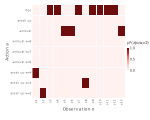

In [180]:
#visualize p(a|o,w)
display(dpdown)  #show the dropdown box to interactively select wk in p(a|o,w=wk)
display(plt_pagow_vis)

#TODO: rather than the number, use the string here for the dropdown (if provided)

In [181]:
p_MI, p_composed, p_perf=plot_three_var_performancemeasures(performance_df, maximum(U_pre), β1, β2, β3)

display(hstack(p_MI, p_composed))
display(p_perf)

#TODO: for 
    #β1 = 8 #inverse temperature for p(o)→p(o|w)
    #β2 = 5 #inverse temperature for p(a)→p(a|o)
    #β3 = 2 #inverse temperature for p(a|o)→p(a|o,w)
#the entropy H(O|W) can't be that large - check for errors, there must be some I(O;W) as well, it can't be zero!


<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 H(O) 
 H(A) 
 H(A|O) 
 H(A) 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 H(O|W) 
 H(A|O) 
 H(A|O,W) 
 H(A|W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 [bits] 
 
 
 Composition of entropic terms 
 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 -2.5 
 0.0 
 2.5 
 5.0 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 
 
 [bits] 
 
 
 Mutual information terms

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 E[U] 
 E[U] 
 
 
 
 E[U] 
 1/β1 I(O;W) 
 1/β2 I(A;O) 
 1/β3 I(A;W|O) 
 J = E[U] - 1/β ∑ I 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 Utility vs. processing-cost trade-off

In [182]:
#compare solution against one-step case

#compare performance measures, EU, J, I(A;W)

util_all = [perf_df_one[end,:E_U], performance_df[end,:E_U],
            perf_df_one[end,:RD_obj], performance_df[end,:Objective_value]]

color_label = ["E[U]_one", "E[U]", "J_one", "J"]

colors = BAdiscretecolorscale(4).f(4)
colscale = Scale.color_discrete_manual(colors[1],colors[1],colors[end],colors[end])

p_perf_comp = plot(x=color_label, y=util_all, color=color_label, Geom.bar(),
                   Guide.ylabel("[utils]"), Guide.xlabel(""), Guide.colorkey(""),
                   Guide.title("One-step solution β=$β vs. \n multi-step β1=$β1, β2=$β2, β3 = $β3"),
                   colscale, Scale.y_continuous(minvalue=0, maxvalue=maximum(U_pre)),
                   BAtheme(key_position = :none))


#compare mutual informations I(A;W)
MI_comp = [perf_df_one[end,:I_aw], performance_df[end,:I_aw]]
color_label = ["I(A;W)_one", "I(A;W)"]

colors = Scale.color_discrete_hue().f(4)
colscale = Scale.color_discrete_manual(colors[end],colors[end])

p_perf_comp_MI = plot(x=color_label, y=MI_comp, color=color_label, Geom.bar(),
                      Guide.ylabel("[bits]"), Guide.xlabel(""), Guide.colorkey(""),
                      Guide.title("I(A;W) for β=$β vs. \n multi-step β1=$β1, β2=$β2, β3 = $β3"),
                      colscale, Scale.y_continuous(minvalue=0), BAtheme(key_position = :none))

display(hstack(p_perf_comp,p_perf_comp_MI))

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 I(A;W)_one 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 -2 
 0 
 2 
 4 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 
 
 [bits] 
 
 
 I(A;W) for β=3 vs. multi-step β1=3, β2=Inf, β3 = 3 
 
 
 
 
 E[U]_one 
 E[U] 
 J_one 
 J 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 One-step solution β=3 vs. multi-step β1=3, β2=Inf, β3 = 3

In [183]:
#compare solutions p(a|w)
plt_cond_one = visualizeBAconditional(p_agw_one, a_vec, w_vec, a_strings, w_strings,
                                      wlabel="w", alabel="a",legendlabel="p*(a|w)_one")

plt_cond_multi = visualizeBAconditional(pagw, a_vec, w_vec, a_strings, w_strings,
                                         wlabel="w", alabel="a",legendlabel="p*(a|w)")

display(plt_cond_one)
display(plt_cond_multi)


<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w)_one 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 a

"Difference: norm(p*(a|w)_one - p*(a|w))=0.0009015878138081347"

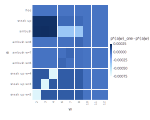

In [184]:
display("Difference: norm(p*(a|w)_one - p*(a|w))=$(norm(p_agw_one-pagw))")

plt_cond_multi = visualizeMatrix(p_agw_one - pagw, w_vec, a_vec, w_strings, a_strings,
xlabel="w", ylabel="a",legendlabel="p*(a|w)_one - p*(a|w)")

In [185]:
#for the paper
#hstack(p_MI, p_composed, p_perf)